# Projeto Final: Modelo de Regressão Linear para Taxa de Vacinação contra COVID-19

## Introdução

Após o desenvolvimento de vacinas contra a Covid-19, iniciou-se uma corrida para imunizar a população mundial. Já era esperado que países mais ricos tomassem a dianteira, mas passado quase um ano das primeiras aplicações, alguns países parecem estagnados e outros ainda muito aquém do esperado. O objetivo deste trabalho é buscar variáveis explicativas que ajudem a entender quais motivos podem influenciar na taxa de vacinação de um país.

Entre várias razões que podem explicar o objeto em estudo, focamos nas seguintes hipóteses:

1. **PIB per capita é proporcional a taxa de vacinação**: Como mencionado no parágrafo anterior, é esperado que países ricos imunizem a sua população com maior agilidade.
2. **Baixa vacinação entre jovens**: É apresentado no conjunto de dados a mediana de idade de cada país. A hipótese a ser testada é a de que quanto maior a proporção de idosos em um país, maior será a sua taxa de vacinação.
3. **Total de óbitos leva a uma maior adesão da população**: Também como parte dos dados, utilizamos o Total de Mortes por Milhão. Inicialmente, espera-se que o número de óbitos impacte na percepção da gravidade da doença, levando assim a mais pessoas aos centros de vacinação.
4. **Acesso a informações de qualidade impacta positivamente no número de vacinados**: Em países com restrições a jornalistas, é esperado uma resposta mais lenta ou até negacionista do governo.
5. **Diferenças regionais**: A fim de entender se há diferenças contidas em cada continente

## Material e Métodos

### Python e bibliotecas

O trabalho foi desenvolvido em python e estruturado na forma de Notebook. As bibliotecas usadas são as seguintes:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

from statsmodels.formula.api import ols
from statsmodels.graphics.gofplots import ProbPlot
from IPython.display import display

Para melhorar a qualidade dos gráficos, o estilo padrão será o usado pelo Seaborn (mesmo quando construido pelo Matplotlib). Avisos de saída serão escondidos para manter o conteúdo mais enxuto.

In [2]:
plt.style.use('seaborn')
warnings.filterwarnings('ignore')

### Conjunto de dados

Os dados de liberdade de imprensa foram retirados do portal [Reporters Without Borders](https://rsf.org/en/ranking) e estão disponíveis no formato CSV no repositório do trabalho no [Github](https://github.com/gui-lisboa/estatisticaufpr/tree/main/analise_de_regressao_linear/dados). Quanto maior o índice, maiores as restrições impostas a jornalistas.

Foram utilizadas a colunas "ISO" (renomeada para "iso_code") e "Score 2020" (renomeada para "press_freedom_score"). As mudanças de nome são necessárias para anexar esse conjunto de dados aos dados da covid.

In [3]:
DADOS_LIBERDADE_IMPRENSA_CSV = './dados/press-freedom-ranking.csv'
COLUNAS_DE_INTERESSE = ['ISO','Score 2020']

dados_liberdade_imprensa = pd.read_csv(DADOS_LIBERDADE_IMPRENSA_CSV, usecols=COLUNAS_DE_INTERESSE)
dados_liberdade_imprensa.rename(columns={'ISO': 'iso_code', "Score 2020": "press_freedom_score"}, inplace=True)

def refatora_decimal_com_virgula_para_float64(serie: pd.Series) -> pd.Series:
    return [float(valor.replace(',', '.')) for valor in serie]

dados_liberdade_imprensa.press_freedom_score = refatora_decimal_com_virgula_para_float64(dados_liberdade_imprensa.press_freedom_score)

dados_liberdade_imprensa = dados_liberdade_imprensa.set_index('iso_code')
dados_liberdade_imprensa

,press_freedom_score
iso_code,
AFG,40.19
AGO,34.06
ALB,30.59
AND,23.32
ARE,43.13
...,...
XKO,30.32
YEM,62.35
ZAF,21.59


Já os dados sobre a COVID-19 tem como fonte o site Our World In Data, que disponibiliza os dados que alimentam o site no repositório [covid-19-data](https://github.com/owid/covid-19-data/blob/master/public/data/latest). O arquivo utilizado também está no repositório deste trabalho.

Neste conjunto foi necessário retirar linhas de países agrupados, estas linhas tem um prefixo "OWID_".

In [4]:
DADOS_COVID_ATUAL_CSV = './dados/owid-covid-latest.csv'
COLUNAS_DE_INTERESSE = [
    'iso_code',
    'location',
    'continent',
    'people_fully_vaccinated_per_hundred',
    'total_deaths_per_million',
    'median_age',
    'gdp_per_capita',
    'extreme_poverty',
    'stringency_index',
]

dados_covid_atual = pd.read_csv(DADOS_COVID_ATUAL_CSV, usecols=COLUNAS_DE_INTERESSE)

def remove_linhas_agrupadas_por_OWID(dataframe: pd.DataFrame) -> pd.DataFrame:
    return dataframe[~dataframe.iso_code.str.contains('OWID_')]

dados_covid_atual = remove_linhas_agrupadas_por_OWID(dados_covid_atual)
dados_covid_atual


,iso_code,continent,location,total_deaths_per_million,people_fully_vaccinated_per_hundred,stringency_index,median_age,gdp_per_capita,extreme_poverty
0,AFG,Asia,Afghanistan,183.781,8.95,27.78,18.6,1803.987,NaN
2,ALB,Europe,Albania,1088.782,34.20,NaN,38.0,11803.431,1.1
3,DZA,Africa,Algeria,137.303,12.08,39.81,29.1,13913.839,0.5
4,AND,Europe,Andorra,1719.368,65.07,48.15,NaN,NaN,NaN
5,AGO,Africa,Angola,51.159,9.77,NaN,16.8,5819.495,NaN
...,...,...,...,...,...,...,...,...,...
217,VNM,Asia,Vietnam,276.931,56.97,NaN,32.6,6171.884,2.0
218,WLF,Oceania,Wallis and Futuna,NaN,53.39,NaN,NaN,NaN,NaN
220,YEM,Asia,Yemen,64.184,1.20,12.04,20.3,1479.147,18.8
221,ZMB,Africa,Zambia,193.862,4.17,43.52,17.7,3689.251,57.5


Assim, juntando os dois conjuntos, retirando linhas com dados incompletos e reconstruindo o índice, temos o dataframe que será usado no decorrer do trabalho.

In [5]:
dados = dados_covid_atual.join(dados_liberdade_imprensa, on='iso_code')
dados.dropna(inplace=True)
dados.reset_index(drop=True, inplace=True)
dados

,iso_code,continent,location,total_deaths_per_million,people_fully_vaccinated_per_hundred,stringency_index,median_age,gdp_per_capita,extreme_poverty,press_freedom_score
0,DZA,Africa,Algeria,137.303,12.08,39.81,29.1,13913.839,0.5,47.26
1,ARG,South America,Argentina,2559.300,67.18,42.59,31.9,18933.907,0.6,28.99
2,AUS,Oceania,Australia,80.812,74.44,72.69,37.9,44648.710,0.5,19.79
3,AUT,Europe,Austria,1438.781,67.50,73.15,44.4,45436.686,0.7,16.34
4,BGD,Asia,Bangladesh,168.463,24.50,44.44,27.5,3523.984,14.8,49.71
...,...,...,...,...,...,...,...,...,...,...
89,USA,North America,United States,2386.942,59.99,50.46,38.3,54225.446,1.2,23.93
90,URY,South America,Uruguay,1761.760,76.43,31.48,35.6,20551.409,0.1,16.38
91,YEM,Asia,Yemen,64.184,1.20,12.04,20.3,1479.147,18.8,62.35
92,ZMB,Africa,Zambia,193.862,4.17,43.52,17.7,3689.251,57.5,38.21


### Modelo de regressão

O modelo escolhido foi um modelo de regressão linear com efeitos aditivos. As variáveis explicativas escolhidas foram:

1. Raiz Quadrada PIB per Capita (gdp_per_capita)
2. Idade Mediana (median_age)
3. Raíz Quadrada Total de Mortes por Milhão (total_deaths_per_million)
4. Índice de Liberdade de Imprensa (press_freedom_score)
5. Continentes (continent) como variável categórica

A transformação do PIB e Morte/Milhão em raízes serve para achatar possíveis diferenças muito grandes que impactam na estimação do modelo.

In [6]:
FORMULA_DO_MODELO = 'people_fully_vaccinated_per_hundred ~ ' \
                    'np.sqrt(gdp_per_capita) + median_age + np.sqrt(total_deaths_per_million) + press_freedom_score +' \
                    'C(continent)'
modelo = ols(FORMULA_DO_MODELO, data=dados)
fit = modelo.fit()

fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                    
===============================================================================================
Dep. Variable:     people_fully_vaccinated_per_hundred   R-squared:                       0.819
Model:                                             OLS   Adj. R-squared:                  0.800
Method:                                  Least Squares   F-statistic:                     42.28
Date:                                 Fri, 10 Dec 2021   Prob (F-statistic):           1.60e-27
Time:                                         22:36:56   Log-Likelihood:                -363.33
No. Observations:                                   94   AIC:                             746.7
Df Residuals:                                       84   BIC:                             772.1
Df Model:                                            9                                         
Covariance Type:                             nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           -23.1797      7.876     -2.943      0.004     -38.843      -7.517
C(continent)[T.Asia]                 12.9123      4.208      3.069      0.003       4.545      21.280
C(continent)[T.Europe]               -7.1164      6.556     -1.086      0.281     -20.153       5.920
C(continent)[T.North America]        11.3772      5.842      1.948      0.055      -0.240      22.994
C(continent)[T.Oceania]              -1.4562     13.520     -0.108      0.914     -28.342      25.429
C(continent)[T.South America]        27.1527      6.331      4.289      0.000      14.562      39.743
np.sqrt(gdp_per_capita)               0.1779      0.039      4.507      0.000       0.099       0.256
median_age                            1.8080      0.341      5.305      0.000       1.130       2.486
np.sqrt(total_deaths_per_million)    -0.2745      0.115     -2.385      0.019      -0.503      -0.046
press_freedom_score                  -0.2311      0.125     -1.844      0.069      -0.480       0.018
==============================================================================
Omnibus:                        0.268   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.874   Jarque-Bera (JB):                0.256
Skew:                           0.119   Prob(JB):                        0.880
Kurtosis:                       2.908   Cond. No.                     1.59e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Diagnósticos do modelo

Para criar os gráficos usados no diagnóstico do modelo, retiramos as seguintes informações do modelo ajustado.

In [7]:
y_ajustados = fit.fittedvalues
residuos = fit.resid
residuos_modulo = np.abs(residuos)
residuos_normalizados = fit.get_influence().resid_studentized_internal
residuos_normalizados_modulo_raizes = np.sqrt(np.abs(residuos_normalizados))
alavancagens = fit.get_influence().hat_matrix_diag
distancias_cook = fit.get_influence().cooks_distance[0]

#### Resíduo vs Ajustado

Valores ajustados bem dispersos centrados em 0, padrão de aumento da diferença para países com taxa de vacinação acima de 80%

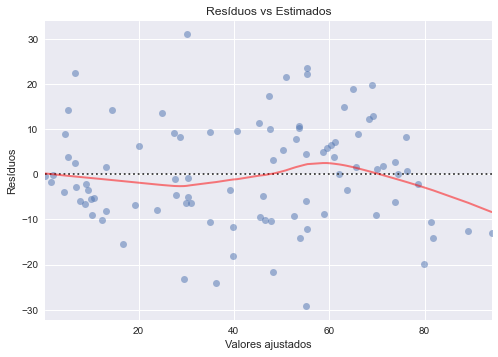

In [8]:
grafico_residuos_vs_estimados = plt.figure()
grafico_residuos_vs_estimados.axes[0] = sns.residplot(x=y_ajustados,
                                                      y=dados.people_fully_vaccinated_per_hundred,
                                                      lowess=True,
                                                      scatter_kws={'alpha': 0.5},
                                                      line_kws={'color': 'red', 'lw': 2, 'alpha': 0.5})

grafico_residuos_vs_estimados.axes[0].set_title('Resíduos vs Estimados')
grafico_residuos_vs_estimados.axes[0].set_xlabel('Valores ajustados')
grafico_residuos_vs_estimados.axes[0].set_ylabel('Resíduos');

#### Disperção Média

Valores bastante dispersos, mas sem formação de padrão que indique problemas no modelo.

,iso_code,continent,location,total_deaths_per_million,people_fully_vaccinated_per_hundred,stringency_index,median_age,gdp_per_capita,extreme_poverty,press_freedom_score
30,GEO,Asia,Georgia,3161.487,25.97,46.30,38.7,9745.079,4.2,28.64
56,MAR,Africa,Morocco,396.146,61.17,67.59,29.6,7485.013,1.0,43.94
73,SYC,Africa,Seychelles,1304.216,78.81,69.44,36.2,26382.287,1.1,25.66
0,DZA,Africa,Algeria,137.303,12.08,39.81,29.1,13913.839,0.5,47.26
28,GAB,Africa,Gabon,123.309,6.23,49.07,23.1,16562.413,3.4,38.60


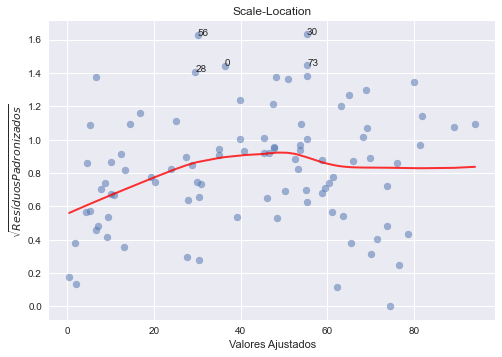

In [9]:
grafico_lm_3 = plt.figure()
plt.scatter(y_ajustados, residuos_normalizados_modulo_raizes, alpha=0.5);
sns.regplot(y_ajustados, residuos_normalizados_modulo_raizes,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 2, 'alpha': 0.8});
grafico_lm_3.axes[0].set_title('Scale-Location')
grafico_lm_3.axes[0].set_xlabel('Valores Ajustados')
grafico_lm_3.axes[0].set_ylabel('$\sqrt{Resíduos Padronizados}$');

maiores_residuos_normalizados_modulo_raizes = np.flip(np.argsort(residuos_normalizados_modulo_raizes), 0)[:5]
for i in maiores_residuos_normalizados_modulo_raizes:
  grafico_lm_3.axes[0].annotate(i,
                            xy=(y_ajustados[i],
                            residuos_normalizados_modulo_raizes[i]));

dados.loc[maiores_residuos_normalizados_modulo_raizes]

#### Gráfico Qunantil-Quantil

Há principalmente dois países muito longe da reta QQ: Gabão e Geórgia. Os demais parecem adequados

,iso_code,continent,location,total_deaths_per_million,people_fully_vaccinated_per_hundred,stringency_index,median_age,gdp_per_capita,extreme_poverty,press_freedom_score
30,GEO,Asia,Georgia,3161.487,25.97,46.30,38.7,9745.079,4.2,28.64
56,MAR,Africa,Morocco,396.146,61.17,67.59,29.6,7485.013,1.0,43.94
73,SYC,Africa,Seychelles,1304.216,78.81,69.44,36.2,26382.287,1.1,25.66
0,DZA,Africa,Algeria,137.303,12.08,39.81,29.1,13913.839,0.5,47.26
28,GAB,Africa,Gabon,123.309,6.23,49.07,23.1,16562.413,3.4,38.60


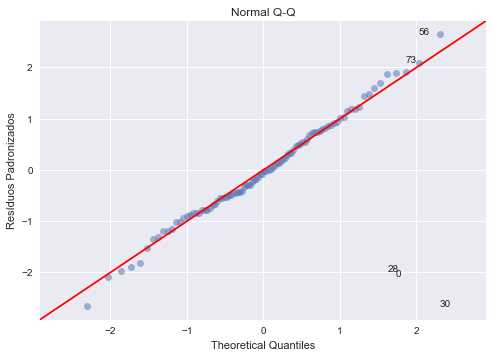

In [10]:
QQ = ProbPlot(residuos_normalizados)
grafico_qq = QQ.qqplot(line='45', alpha=0.5, lw=1)
grafico_qq.axes[0].set_title('Normal Q-Q')
grafico_qq.axes[0].set_xlabel('Theoretical Quantiles')
grafico_qq.axes[0].set_ylabel('Resíduos Padronizados');

maiores_residuos_padronizados = np.flip(np.argsort(np.abs(residuos_normalizados)), 0)[:5]
for r, i in enumerate(maiores_residuos_padronizados):
    grafico_qq.axes[0].annotate(i,
                               xy=(np.flip(QQ.theoretical_quantiles, 0)[r],
                                   residuos_normalizados[i]));

dados.loc[maiores_residuos_padronizados]

#### Gráfico de Alavancagem

Austrália muito longe dos demais, provavelmente pelo peso que tem na Oceania, usada como variável categórica.

,iso_code,continent,location,total_deaths_per_million,people_fully_vaccinated_per_hundred,stringency_index,median_age,gdp_per_capita,extreme_poverty,press_freedom_score
2,AUS,Oceania,Australia,80.812,74.44,72.69,37.9,44648.710,0.5,19.79
30,GEO,Asia,Georgia,3161.487,25.97,46.30,38.7,9745.079,4.2,28.64
15,CHN,Asia,China,3.210,77.90,59.72,38.7,15308.712,0.7,78.72
73,SYC,Africa,Seychelles,1304.216,78.81,69.44,36.2,26382.287,1.1,25.66
89,USA,North America,United States,2386.942,59.99,50.46,38.3,54225.446,1.2,23.93


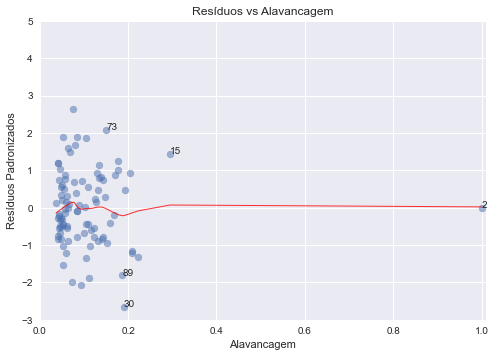

In [11]:
grafico_alavancagens = plt.figure();
plt.scatter(alavancagens, residuos_normalizados, alpha=0.5);
sns.regplot(alavancagens, residuos_normalizados,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8});
grafico_alavancagens.axes[0].set_xlim(0, max(alavancagens)+0.01)
grafico_alavancagens.axes[0].set_ylim(-3, 5)
grafico_alavancagens.axes[0].set_title('Resíduos vs Alavancagem')
grafico_alavancagens.axes[0].set_xlabel('Alavancagem')
grafico_alavancagens.axes[0].set_ylabel('Resíduos Padronizados');

maiores_alavancagens = np.flip(np.argsort(distancias_cook), 0)[:5]
for i in maiores_alavancagens:
    grafico_alavancagens.axes[0].annotate(i,
                               xy=(alavancagens[i],
                               residuos_normalizados[i]));

dados.loc[maiores_alavancagens]

### Correções

Pelos gráficos acima, podemos fazer algumas correções a fim de melhorar o modelo. Pela análise dos resíduos, os países que se destacam tem pouca liberdade de imprensa (press_freedom_index alto), isso pode ter influênciado os registros de mortes por COVID.

Retirando estes países por terem dados não confiáveis, temos:

In [12]:
modelo_corrigido = ols(FORMULA_DO_MODELO, data=dados.drop(maiores_residuos_normalizados_modulo_raizes))
fit_corrigido = modelo_corrigido.fit()

fit_corrigido.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     OLS Regression Results                                    
===============================================================================================
Dep. Variable:     people_fully_vaccinated_per_hundred   R-squared:                       0.862
Model:                                             OLS   Adj. R-squared:                  0.847
Method:                                  Least Squares   F-statistic:                     54.93
Date:                                 Fri, 10 Dec 2021   Prob (F-statistic):           2.43e-30
Time:                                         22:36:58   Log-Likelihood:                -331.57
No. Observations:                                   89   AIC:                             683.1
Df Residuals:                                       79   BIC:                             708.0
Df Model:                                            9                                         
Covariance Type:                             nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                           -21.3220      7.138     -2.987      0.004     -35.531      -7.113
C(continent)[T.Asia]                 15.2962      4.134      3.700      0.000       7.068      23.525
C(continent)[T.Europe]               -6.0783      6.671     -0.911      0.365     -19.356       7.199
C(continent)[T.North America]        11.8101      5.542      2.131      0.036       0.778      22.842
C(continent)[T.Oceania]               0.2573     12.121      0.021      0.983     -23.869      24.383
C(continent)[T.South America]        27.1149      5.986      4.530      0.000      15.200      39.029
np.sqrt(gdp_per_capita)               0.1766      0.036      4.896      0.000       0.105       0.248
median_age                            1.7253      0.316      5.463      0.000       1.097       2.354
np.sqrt(total_deaths_per_million)    -0.2432      0.105     -2.325      0.023      -0.451      -0.035
press_freedom_score                  -0.2533      0.114     -2.216      0.030      -0.481      -0.026
==============================================================================
Omnibus:                        1.762   Durbin-Watson:                   1.986
Prob(Omnibus):                  0.414   Jarque-Bera (JB):                1.571
Skew:                           0.197   Prob(JB):                        0.456
Kurtosis:                       2.482   Cond. No.                     1.67e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.67e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Comparando os valores de $R^{2}$ e da estatística F, notamos a melhora do modelo:

In [13]:
comparacao = pd.DataFrame({
    'Modelo': ['Modelo Inicial', 'Modelo Corrigido'],
    'RQuadrado': [fit.rsquared, fit_corrigido.rsquared],
    'EstatisticaF': [fit.fvalue, fit_corrigido.fvalue],
})

comparacao

,Modelo,RQuadrado,EstatisticaF
0,Modelo Inicial,0.819174,42.281654
1,Modelo Corrigido,0.862218,54.929717


## Conclusão

É significativa a influência do PIB per capita e da idade da população, estes fatores geram um coeficiente positivo quando estimamos a taxa de vacinação.

Algo que pode ser revisto é a influência negativa que o total de mortes por milhão causa na variável resposta, uma vez que foi assumido na introdução que a expectativa era de uma melhor resposta frente a alta letalidade do virus no país.

A falta de liberdade de imprensa também impacta negativamente na taxa de vacinação. Lembrando que quanto maior o índice, menor a liberdade para jornalistas e portanto, o coeficiente negativo mostra que a restrição diminui o valor esperado da resposta.

Apesar do continent Africano (intercepto do modelo) estar muito aquém nos índices de vacinação, é curioso ver que para condições iguais não há p-valor baixo o suficiente que descarte a hipótese de um país possuir a mesma taxa de vacinação da Europa ou Oceania (majoritariamente, Australia como vimos pela alavancagem) quando as demais variáveis são mantidas. Já os países asiáticos e das américas tem respondido melhor a vacinação.